# LLM Science exam

Most of the notebooks in this competition are based on implemenatation via Pytorch and Deberta.

This notebook suggests slightly different approach via Tensorflow and Distilbert.

For further improvement of the model KFold cross-validation and Augmentation techniques were used.

## Importing dependencies

In [1]:
#Import  dependencies
import tensorflow as tf
from tensorflow.keras import callbacks
from typing import Optional, Union
import pandas as pd
import numpy as np
from datasets import Dataset
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers import TFBertForMultipleChoice, EarlyStoppingCallback, BertTokenizer, DistilBertTokenizer, TFDistilBertForMultipleChoice, pipeline, AutoTokenizer
from transformers.optimization import Adafactor
from sklearn.preprocessing import *
from sklearn.model_selection import *
import matplotlib.pyplot as plt
import seaborn as sns
import random
pd.set_option('display.max_colwidth', 1000)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Augmentation + EDA

Apart from the training dataset from the competition that consists of only 200 rows, we will use the additional datasets with further examples, generated by 
RADEK OSMULSKI (https://www.kaggle.com/datasets/radek1/additional-train-data-for-llm-science-exam)

In [2]:
df_train = pd.concat([
    pd.read_csv('/kaggle/input/kaggle-llm-science-exam/train.csv'),
    pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/6000_train_examples.csv'),
    pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/extra_train_set.csv'),
    pd.read_csv('/kaggle/input/15k-high-quality-examples/15k_gpt3.5-turbo.csv')
])
df_train.drop('id', inplace = True, axis = 1)
df_test = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/test.csv')

In [3]:
#distilbert-base-uncased
tokenizer = DistilBertTokenizer.from_pretrained("/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")
model = TFDistilBertForMultipleChoice.from_pretrained("/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")

Some layers from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing TFDistilBertForMultipleChoice: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForMultipleChoice were not initialized from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifie

In [4]:
# credit to https://www.kaggle.com/code/satyaprakashshukl/kaggle-llm-science/notebook
# Initialize the pipeline for masked language modeling using BERT
mlm_fill_mask = pipeline(task="fill-mask", model="/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")

# Function to perform data augmentation using contextual word embeddings
def augment_data(original_df, num_augmented_rows):
    augmented_data = []
    original_rows = original_df.shape[0]

    # Function for contextual word embeddings augmentation
    def contextual_embeddings(text):
        # Tokenize the text
        tokenized_text = tokenizer(text, return_tensors="tf")

        # Find masked positions in the tokenized text
        masked_positions = [i for i, token in enumerate(tokenized_text["input_ids"][0]) if token == tokenizer.mask_token_id]

        # If no masked positions found, return the original text
        if not masked_positions:
            return text

        # Randomly select one of the masked positions
        random_masked_position = random.choice(masked_positions)

        # Predict the masked word using masked language modeling
        masked_text = text.replace("[MASK]", tokenizer.mask_token)
        predicted_word = mlm_fill_mask(masked_text)[0]["token_str"]

        # Replace the masked word in the text with the predicted word
        augmented_text = text.replace(tokenizer.mask_token, predicted_word, 1)

        return augmented_text

    for _ in range(num_augmented_rows):
        original_row = original_df.iloc[random.randint(0, original_rows - 1)]
        augmented_row = original_row.copy()

        # Apply augmentation techniques to "prompt"
        augmented_row["prompt"] = contextual_embeddings(original_row["prompt"])

        augmented_data.append(augmented_row)

    return augmented_data

desired_rows = 25000

# Calculate the number of rows needed to achieve the desired total rows
additional_rows = desired_rows - df_train.shape[0]

# Augment the data
augmented_data = augment_data(df_train, additional_rows)

# Convert the augmented data to a dataframe
augmented_df = pd.DataFrame(augmented_data)

# Concatenate the original dataframe with the augmented dataframe to get the final dataframe with 3000 rows
df_train = pd.concat([df_train, augmented_df], ignore_index=True)

augmented_df.head(2) # sanity check

,prompt,A,B,C,D,E,answer
12914,Who succeeded John Robarts as the leader of the Ontario Progressive Conservative Party and Premier?,Not mentioned in the Wikipedia excerpt,None of the above,Frederick McIntosh Cass,John Robarts,Bill Davis,E
12321,"What was the name of the founder of Linkville, an unincorporated community in Marshall County, Indiana?",M J Link,Linkville,United States,Indiana,Marshall County,A


In [5]:
df_test['answer'] = 'A'

In [6]:
for col in df_train.columns[:-1]:
    print(f'the longest string in {col} column: {df_train[col].str.len().max()}')
    print(f'the average length of the string in {col} column: {df_train[col].str.len().mean()}') 
    # some strings are longer than 512. We will not truncate the strings during preprocessing

the longest string in prompt column: 383
the average length of the string in prompt column: 83.93188
the longest string in A column: 674
the average length of the string in A column: 73.38756
the longest string in B column: 683
the average length of the string in B column: 73.44664
the longest string in C column: 677
the average length of the string in C column: 73.3862
the longest string in D column: 746
the average length of the string in D column: 73.44132
the longest string in E column: 695
the average length of the string in E column: 73.3234


<Axes: xlabel='answer', ylabel='count'>

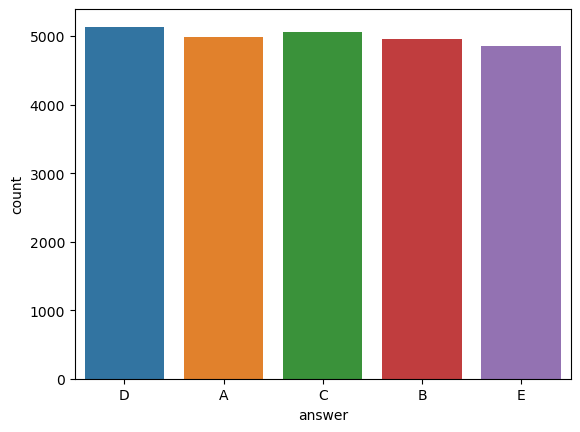

In [7]:
sns.countplot(df_train, x = 'answer') # validating that the classes are uniformly distributed

# Preprocessing

In [8]:
df_train = Dataset.from_pandas(df_train)
df_test = Dataset.from_pandas(df_test)

In [9]:
# Adapted from Huggingface Multiple Choice https://huggingface.co/docs/transformers/tasks/multiple_choice
options = 'ABCDE'
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}

def preprocess(example):
    # The AutoModelForMultipleChoice class expects a set of question/answer pairs
    # so we'll copy our question 5 times before tokenizing
    first_sentence = [example['prompt']] * 5
    second_sentence = []
    for option in options:
        second_sentence.append(example[option])
    # Our tokenizer will turn our text into token IDs BERT can understand
    tokenized_example = tokenizer(first_sentence, second_sentence, truncation=True) # tokenizer call using 'text_pair' which basically just adds a separator between the two sentences
    tokenized_example['label'] = option_to_index[example['answer']]
    return tokenized_example

In [10]:
tokenized_train_ds = df_train.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_test_ds = df_test.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])

  0%|          | 0/25000 [00:00<?, ?ex/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/200 [00:00<?, ?ex/s]

In [11]:

@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer:  tokenizer #PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="tf",
        )

        batch = {k: tf.reshape(v, (batch_size, num_choices, -1)) for k, v in batch.items()}
        batch["labels"] = tf.convert_to_tensor(labels, dtype=tf.int32)
        return batch
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)

# **Training**

In [12]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    #patience=50,
                    restore_best_weights=True,
                    start_from_epoch=3,
                )
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                              factor=0.5, 
                                              patience=2,
                                              verbose=1, 
                                              min_lr=1e-7)
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [13]:
batch_size = 16
num_train_epochs = 5
learning_rate = 1e-5
folds = 3 

In [14]:
kfold = KFold(n_splits = folds)
models = {}
histories = {}

for fold, (train_ids, test_ids) in enumerate(kfold.split(tokenized_train_ds)):
    print(f'FOLD {fold}')
    print('-----------------------------------')
    
    # Subset the dataset.
    train_subset = tokenized_train_ds.select(train_ids)
    test_subset = tokenized_train_ds.select(test_ids)
    
    train_subset = model.prepare_tf_dataset(
    train_subset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
    )

    test_subset = model.prepare_tf_dataset(
    test_subset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
    )
    
    tf.keras.backend.clear_session()
    
    model = TFDistilBertForMultipleChoice.from_pretrained(
    "/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")
    optimizer = tf.keras.optimizers.Adafactor( # using Adafactor helps to avoid OOM by larger batch_size
    learning_rate=1e-4,
    weight_decay=0.05             
    )
    model.compile(
    optimizer=optimizer,
    metrics=['accuracy'],
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    )
    
    history = model.fit(
    train_subset,
    validation_data=test_subset,
    epochs=num_train_epochs,
    # batch_size=batch_size,
    callbacks=[EarlyStopping, reduce_lr, model_checkpoint],
    #steps_per_epoch=steps_per_epoch
    )

    # Store the model and history in the dictionaries
    models[fold] = model
    histories[fold] = history

FOLD 0
-----------------------------------


Some layers from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing TFDistilBertForMultipleChoice: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForMultipleChoice were not initialized from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifie

Epoch 1/5
1042/1042 [==============================] - 786s 709ms/step - loss: 1.5545 - accuracy: 0.3043 - val_loss: 1.4689 - val_accuracy: 0.4154 - lr: 1.0000e-04
Epoch 2/5
1042/1042 [==============================] - 708s 680ms/step - loss: 1.4393 - accuracy: 0.3909 - val_loss: 1.3853 - val_accuracy: 0.4404 - lr: 1.0000e-04
Epoch 3/5
1042/1042 [==============================] - 702s 674ms/step - loss: 1.3370 - accuracy: 0.4491 - val_loss: 1.3575 - val_accuracy: 0.4544 - lr: 1.0000e-04
Epoch 4/5
1042/1042 [==============================] - 704s 676ms/step - loss: 1.2342 - accuracy: 0.5038 - val_loss: 1.3480 - val_accuracy: 0.4633 - lr: 1.0000e-04
Epoch 5/5
1042/1042 [==============================] - 708s 680ms/step - loss: 1.1162 - accuracy: 0.5552 - val_loss: 1.3673 - val_accuracy: 0.4641 - lr: 1.0000e-04
FOLD 1
-----------------------------------


Some layers from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing TFDistilBertForMultipleChoice: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForMultipleChoice were not initialized from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifie

Epoch 1/5
1042/1042 [==============================] - 786s 715ms/step - loss: 1.5366 - accuracy: 0.3188 - val_loss: 1.4662 - val_accuracy: 0.3865 - lr: 1.0000e-04
Epoch 2/5
1042/1042 [==============================] - 697s 668ms/step - loss: 1.3816 - accuracy: 0.4168 - val_loss: 1.4194 - val_accuracy: 0.4107 - lr: 1.0000e-04
Epoch 3/5
1042/1042 [==============================] - 697s 668ms/step - loss: 1.2772 - accuracy: 0.4727 - val_loss: 1.4185 - val_accuracy: 0.4198 - lr: 1.0000e-04
Epoch 4/5
1042/1042 [==============================] - 698s 669ms/step - loss: 1.1652 - accuracy: 0.5293 - val_loss: 1.4642 - val_accuracy: 0.4265 - lr: 1.0000e-04
Epoch 5/5
1042/1042 [==============================] - ETA: 0s - loss: 1.0496 - accuracy: 0.5862
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1042/1042 [==============================] - 705s 677ms/step - loss: 1.0496 - accuracy: 0.5862 - val_loss: 1.5191 - val_accuracy: 0.4300 - lr: 1.0000e-04
FOLD 2
----------

Some layers from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing TFDistilBertForMultipleChoice: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForMultipleChoice were not initialized from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifie

Epoch 1/5
1042/1042 [==============================] - 776s 705ms/step - loss: 1.5521 - accuracy: 0.3115 - val_loss: 1.4671 - val_accuracy: 0.3919 - lr: 1.0000e-04
Epoch 2/5
1042/1042 [==============================] - 699s 670ms/step - loss: 1.4033 - accuracy: 0.4117 - val_loss: 1.4064 - val_accuracy: 0.4199 - lr: 1.0000e-04
Epoch 3/5
1042/1042 [==============================] - 655s 628ms/step - loss: 1.3092 - accuracy: 0.4636 - val_loss: 1.3721 - val_accuracy: 0.4343 - lr: 1.0000e-04
Epoch 4/5
1042/1042 [==============================] - 705s 676ms/step - loss: 1.2221 - accuracy: 0.5022 - val_loss: 1.3490 - val_accuracy: 0.4509 - lr: 1.0000e-04
Epoch 5/5
1042/1042 [==============================] - 708s 679ms/step - loss: 1.1273 - accuracy: 0.5510 - val_loss: 1.3422 - val_accuracy: 0.4651 - lr: 1.0000e-04


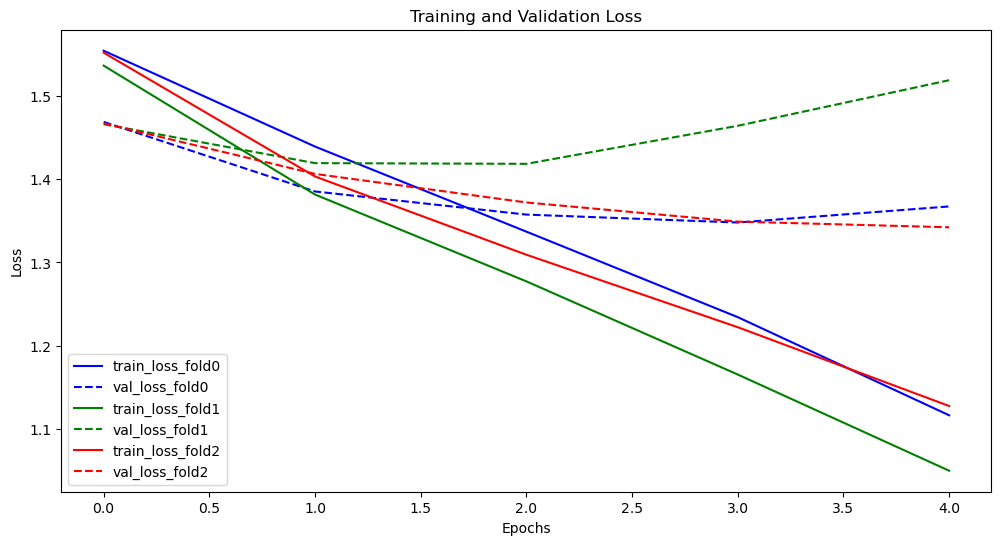

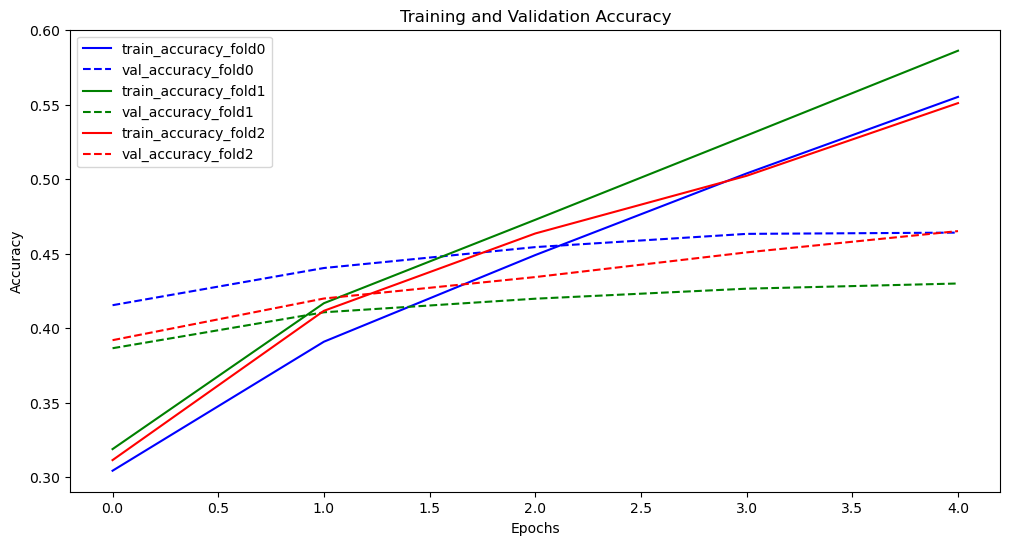

In [15]:
# Create lists to store training and validation metrics for each fold
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define line styles or colors for each fold
line_styles = ['-', '--']
colors = ['blue', 'green', 'red']

for fold in range(folds):
    history = histories[fold]
    
    # Append training and validation metrics to the respective lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
for fold in range(folds):
    plt.plot(train_losses[fold], label=f'train_loss_fold{fold}', linestyle=line_styles[0], color=colors[fold])
    plt.plot(val_losses[fold], label=f'val_loss_fold{fold}', linestyle=line_styles[1], color=colors[fold])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
for fold in range(folds):
    plt.plot(train_accuracies[fold], label=f'train_accuracy_fold{fold}', linestyle=line_styles[0], color=colors[fold])
    plt.plot(val_accuracies[fold], label=f'val_accuracy_fold{fold}', linestyle=line_styles[1], color=colors[fold])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Predicting on the test set 

In [16]:
tf_test_set = model.prepare_tf_dataset(
    tokenized_test_ds,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
    )

fold_preds = []
for fold in range(folds):
    tf.keras.backend.clear_session()
    model = models[fold]
    print(f'\nFold {fold} inference...')
    pred = model.predict(tf_test_set).logits
    fold_preds.append(pred)


Fold 0 inference...
13/13 [==============================] - 5s 242ms/step

Fold 1 inference...
13/13 [==============================] - 5s 250ms/step

Fold 2 inference...
13/13 [==============================] - 5s 242ms/step


In [17]:
df_test = pd.DataFrame(df_test) # converting back to Pandas

In [18]:
# Combine predictions from all folds
combined_preds = np.mean(fold_preds, axis=0)  # You can use mean or another aggregation method

# Convert predictions to answer letters
predictions_as_ids = np.argsort(-combined_preds, axis=1)
predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_as_ids]

# Create predictions as a string
predictions_as_string = [
    ' '.join(row) for row in predictions_as_answer_letters[:, :3]
]

# Assuming df_test is a pandas DataFrame, you can add the predictions as a new column
df_test['prediction'] = predictions_as_string

# Print the first few predictions
print(predictions_as_string[:3])

['D B C', 'D C A', 'A C E']


In [19]:
submission = df_test[['id', 'prediction']]
submission.to_csv('submission.csv', index=False)

pd.read_csv('submission.csv').head(2)

,id,prediction
0,0,D B C
1,1,D C A


## More to do

- implementing another strategy for augmentation,
- another pretrained model as basic
- finetuning training parameters